## Extraordinary Hackers. Gas Analysis

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import HTML, display

from config import PROJECT_ID, GAS_ANALYSIS_DATASET_NAME, INITIAL_TS, SNAPSHOT_TS, \
    GAS_ANALYSIS_DISTRIBUTION_TABLE_NAME, GAS_SPEND_BY_CONTRACT_TABLE_NAME
from utils import drop_table, create_table, get_df

DROP_TABLES = True
CREATE_TABLES = True

### Distribution Rule

<table style="text-align: center">
    <thead>
        <tr>
            <th rowspan=2> Fee spending to created contracts, ETH </th>
            <th colspan=3>Grade</th>
        </tr>
        <tr>
            <th>1</th>
            <th>2</th>
            <th>3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"> - by contract creators, excluding fee from contract creator address </td>
            <td> > 0 ETH </td>
            <td> > 0.5 ETH </td>
            <td> > 10 ETH </td>
        </tr>
        <tr>
            <td style="text-align: left"> - by fabric creators </td>
            <td> - </td>
            <td> > 0 ETH </td>
            <td> > 10 ETH </td>
        </tr>
    </tbody>
</table>

In [2]:
spending_fee_by_contract_creator = [0, 0.5, 10]
spending_fee_by_fabric_creator = [0, 0, 10]

### Create Table with Spending Gas by Contracts

In [3]:
query_1 = f'''
        WITH gas_spend AS (
            SELECT
                from_address,
                to_address,
                sum(cast(receipt_gas_used as numeric) * cast(gas_price as numeric))/1e18 as fee
            FROM `bigquery-public-data.crypto_ethereum.transactions`
            WHERE block_timestamp >= '{INITIAL_TS}'
              AND block_timestamp <= '{SNAPSHOT_TS}'
            GROUP BY from_address, to_address
            ORDER BY fee DESC
        ),
        traces_with_contracts_creation AS (
            SELECT
                transaction_hash,
                from_address,
                to_address
            FROM `bigquery-public-data.crypto_ethereum.traces`
            WHERE block_timestamp >= '{INITIAL_TS}'
              AND block_timestamp <= '{SNAPSHOT_TS}'
              AND trace_type ='create'
              AND status = 1),
        tx_sender_and_hash AS (
            SELECT
                from_address,
                `hash` as transaction_hash
            FROM `bigquery-public-data.crypto_ethereum.transactions`
            WHERE block_timestamp >= '{INITIAL_TS}'
              AND block_timestamp <= '{SNAPSHOT_TS}')
        SELECT
            contract_address,
            fabric_address,
            creator_address,
            sum(fee) as fee
        FROM (
            SELECT
                contracts_creation.to_address as contract_address,
                if(contracts_creation.from_address = tx_sender.from_address, null, contracts_creation.from_address)  as fabric_address,
                tx_sender.from_address as creator_address,
                gas.fee as fee
            FROM gas_spend as gas
            INNER JOIN traces_with_contracts_creation as contracts_creation 
                ON gas.to_address = contracts_creation.to_address
            LEFT JOIN tx_sender_and_hash as tx_sender 
                ON contracts_creation.transaction_hash = tx_sender.transaction_hash 
                   AND gas.from_address != tx_sender.from_address)
        GROUP BY contract_address, fabric_address, creator_address
'''

if DROP_TABLES:
    drop_table(GAS_SPEND_BY_CONTRACT_TABLE_NAME, dataset_name=GAS_ANALYSIS_DATASET_NAME)
if CREATE_TABLES:
    create_table(query_1, GAS_SPEND_BY_CONTRACT_TABLE_NAME, dataset_name=GAS_ANALYSIS_DATASET_NAME)

Table gas_analysis:gas_spend_by_contract has not been deleted.
404 DELETE https://bigquery.googleapis.com/bigquery/v2/projects/cosmic-keep-223223/datasets/gas_analysis/tables/gas_spend_by_contract?prettyPrint=false: Not found: Table cosmic-keep-223223:gas_analysis.gas_spend_by_contract
Table gas_analysis:gas_spend_by_contract has been created and filled 4456059 rows.


### Create Table with Distribution by Contract and Fabric Creators

In [6]:
query_2 = f'''
        WITH fee_by_fabric AS (
            SELECT
                fabric_address,
                sum(fee) as sum_fee
            FROM `{PROJECT_ID}.{GAS_ANALYSIS_DATASET_NAME}.{GAS_SPEND_BY_CONTRACT_TABLE_NAME}`
            WHERE fabric_address is not null
              AND creator_address is not null
            GROUP BY fabric_address
            ),
        fabric_creators AS (
            SELECT
                contract_address as fabric_address,
                creator_address as fabric_creator
            FROM `{PROJECT_ID}.{GAS_ANALYSIS_DATASET_NAME}.{GAS_SPEND_BY_CONTRACT_TABLE_NAME}`
            WHERE contract_address IN (
                SELECT DISTINCT fabric_address
                FROM `{PROJECT_ID}.{GAS_ANALYSIS_DATASET_NAME}.{GAS_SPEND_BY_CONTRACT_TABLE_NAME}`
                )
              AND creator_address is not null
            )
        SELECT
            'Fabric Creator' as subtype,
            fabric_creator as address,
            fee_3 as sum_fee,
            CASE
                WHEN fee_3 > {spending_fee_by_fabric_creator[2]} THEN 3
                WHEN fee_3 > {spending_fee_by_fabric_creator[1]} THEN 2
                WHEN fee_3 > {spending_fee_by_fabric_creator[0]} THEN 1
                ELSE null
            END
            AS grade
        FROM (
            SELECT
                fabric_creator,
                sum(sum_fee) as fee_3
            FROM fee_by_fabric as ff
            LEFT JOIN fabric_creators as fc ON ff.fabric_address = fc.fabric_address
            GROUP BY fabric_creator)
        WHERE fabric_creator is not null
        UNION ALL
        SELECT
            'Contract Creator' as subtype,
            address,
            sum_fee,
            CASE
                WHEN sum_fee > {spending_fee_by_contract_creator[2]} THEN 3
                WHEN sum_fee > {spending_fee_by_contract_creator[1]} THEN 2
                WHEN sum_fee > {spending_fee_by_contract_creator[0]} THEN 1
                ELSE null
            END
            AS grade
        FROM (
            SELECT
                creator_address as address,
                sum(fee) as sum_fee
            FROM `{PROJECT_ID}.{GAS_ANALYSIS_DATASET_NAME}.{GAS_SPEND_BY_CONTRACT_TABLE_NAME}`
            WHERE creator_address is not null
            GROUP BY creator_address)
        ORDER BY sum_fee DESC;
'''

if DROP_TABLES:
    drop_table(GAS_ANALYSIS_DISTRIBUTION_TABLE_NAME, dataset_name=GAS_ANALYSIS_DATASET_NAME)
if CREATE_TABLES:
    create_table(query_2, GAS_ANALYSIS_DISTRIBUTION_TABLE_NAME, dataset_name=GAS_ANALYSIS_DATASET_NAME)

Table gas_analysis:gas_analysis_distribution has not been deleted.
404 DELETE https://bigquery.googleapis.com/bigquery/v2/projects/cosmic-keep-223223/datasets/gas_analysis/tables/gas_analysis_distribution?prettyPrint=false: Not found: Table cosmic-keep-223223:gas_analysis.gas_analysis_distribution
Table gas_analysis:gas_analysis_distribution has been created and filled 344650 rows.


### Get Spending Fee Distribution

In [7]:
query_3 = f'''
    SELECT
        subtype,
        CASE
            WHEN sum_fee <= 0.01 THEN 0.01
            WHEN sum_fee <= 0.1 THEN 0.1
            WHEN sum_fee <= 1 THEN 1
            WHEN sum_fee <= 10 THEN 10
            WHEN sum_fee <= 100 THEN 100
            WHEN sum_fee <= 1000 THEN 1000
            WHEN sum_fee > 1000 THEN 10000
        END
        AS fee_class,
        count(address) as number_of_creators,
        cast(avg(grade) as INT64) as grade
    FROM `{PROJECT_ID}.{GAS_ANALYSIS_DATASET_NAME}.{GAS_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
    GROUP BY subtype, fee_class
    ORDER BY subtype, fee_class;
'''
spending_fee_distr_df = get_df(query_3)
display(HTML(spending_fee_distr_df.to_html(index=False)))

subtype,fee_class,number_of_creators,grade
Contract Creator,0.01,280794,1
Contract Creator,0.10,28844,1
Contract Creator,1.00,17578,1
Contract Creator,10.00,9590,2
Contract Creator,100.00,4441,3
Contract Creator,1000.00,1249,3
Contract Creator,10000.00,233,3
Fabric Creator,0.01,642,2
Fabric Creator,0.10,404,2
Fabric Creator,1.00,344,2


In [8]:
spending_fee_distr_by_grade_df = spending_fee_distr_df.groupby(['subtype', 'grade'])['number_of_creators'].agg(sum).reset_index()
display(HTML(spending_fee_distr_by_grade_df.to_html(index=False)))

subtype,grade,number_of_creators
Contract Creator,1,327216
Contract Creator,2,9590
Contract Creator,3,5923
Fabric Creator,2,1648
Fabric Creator,3,273


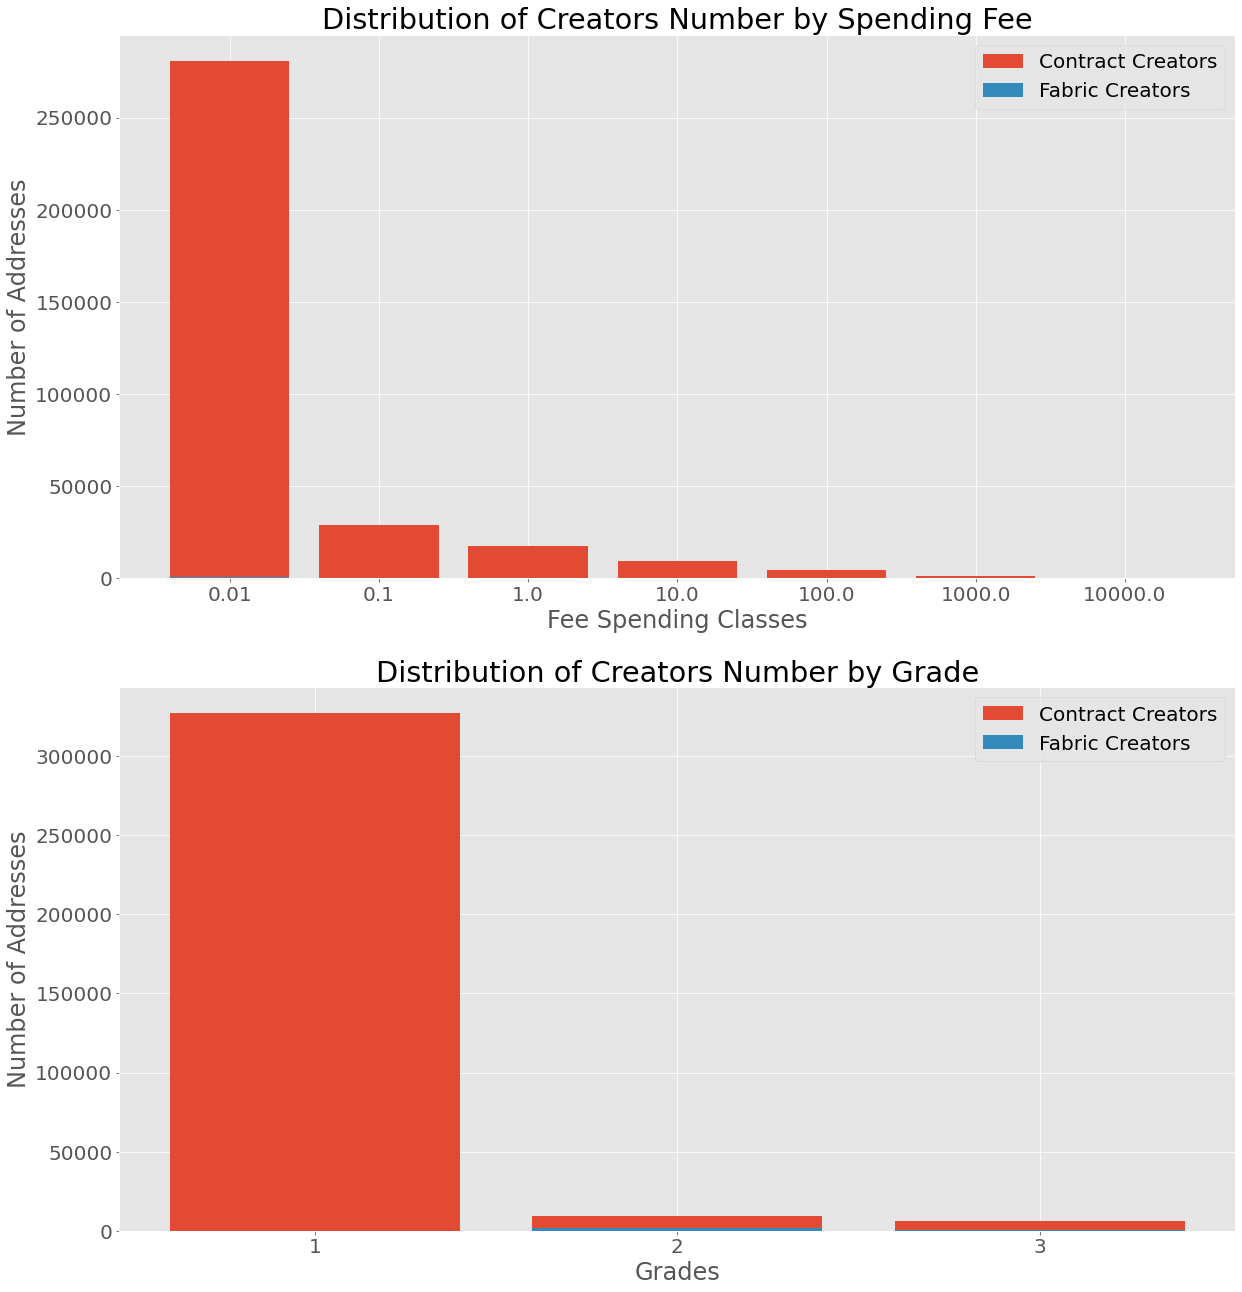

In [9]:
mpl.rcParams['figure.figsize'] = (20.0, 22.0)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})
fig, (ax1, ax2) = plt.subplots(2)

ax1.set_title('Distribution of Creators Number by Spending Fee')
ax1.bar(
    spending_fee_distr_df[spending_fee_distr_df.subtype=='Contract Creator'].fee_class.astype('str'),
    spending_fee_distr_df[spending_fee_distr_df.subtype=='Contract Creator'].number_of_creators),
ax1.bar(
    spending_fee_distr_df[spending_fee_distr_df.subtype=='Fabric Creator'].fee_class.astype('str'),
    spending_fee_distr_df[spending_fee_distr_df.subtype=='Fabric Creator'].number_of_creators)
ax1.set_ylabel('Number of Addresses')
ax1.set_xlabel('Fee Spending Classes')
ax1.legend(labels=['Contract Creators', 'Fabric Creators'])

ax2.set_title('Distribution of Creators Number by Grade')
ax2.bar(
    spending_fee_distr_by_grade_df[spending_fee_distr_by_grade_df.subtype=='Contract Creator'].grade.astype('str'),
    spending_fee_distr_by_grade_df[spending_fee_distr_by_grade_df.subtype=='Contract Creator'].number_of_creators),
ax2.bar(
    spending_fee_distr_by_grade_df[spending_fee_distr_by_grade_df.subtype=='Fabric Creator'].grade.astype('str'),
    spending_fee_distr_by_grade_df[spending_fee_distr_by_grade_df.subtype=='Fabric Creator'].number_of_creators)
ax2.set_ylabel('Number of Addresses')
ax2.set_xlabel('Grades')
ax2.legend(labels=['Contract Creators', 'Fabric Creators'])

plt.show()